In [59]:
import os
from PIL import Image
import numpy as np
from numpy import asarray
import mahotas
import cv2
import matplotlib.pyplot as plt

In [60]:
# constants

# 1
P = 256

# 4
K = 5

In [61]:
img = Image.open("files/image.jpg")

### 1. Загрузка и визуализация изображения
#### a) Числовые характеристики изображения

In [62]:
print(f"Размерность изображения: {img.size[0]}x{img.size[1]}")
print(f"Число световых каналов: {len(img.getbands())}")
print(f"Яркостное разрешение: {len(img.getbands()) * 8} bits")


Размерность изображения: 1600x1060
Число световых каналов: 3
Яркостное разрешение: 24 bits


#### б) Если изображение содержит много цветовых каналов, то привести его к одноканальному (в градациях серого) в диапазоне [0; P], P = 255 (яркостное разрешение – 1 байт) 

In [63]:
gray = img.convert('L')
gray.save('files/greyscale.jpg')

#### в) Статистические характеристики изображения

In [64]:
img_array = asarray(gray)

print(f"Динамический диапазон яркостей: [{img_array.min()}, {img_array.max()}]")
print(f"% использования яркостного диапазона: {len(np.unique(img_array))/256 * 100}%")
print(f"Число различных яркостей: {len(np.unique(img_array))}")

Динамический диапазон яркостей: [0, 255]
% использования яркостного диапазона: 100.0%
Число различных яркостей: 256


#### г) Рассчитать статистические характеристики изображения и заполнить таблицу.
источник: https://www.geeksforgeeks.org/mahotas-haralick-features/

### 2. Контрастирование в яркостных окнах

#### a) Масштабирование динамического диапазона на интервал [0; 255]

In [65]:
def set_contrast(img_array, low:int, high:int):
    mmin = img_array.min()
    mmax = img_array.max()

    new_img_array = np.where(img_array < low, np.zeros(img_array.shape), img_array)
    new_img_array = np.where(img_array > P-1, np.full(img_array.shape, P-1), img_array)
    new_img_array = np.where((low <= img_array) & (img_array <= P-1), (img_array - mmin) / (mmax - mmin) * (high - low) + low, img_array)

    return new_img_array.astype(np.uint8)


In [66]:
img_array = set_contrast(img_array, 0, 255)
Image.fromarray(img_array).save('files/2/contrast_0_255.jpg')

#### б) Провести отображение указанных яркостных диапазонов на максимально возможный диапазон яркостей

In [67]:
# [0, 120]

new_img_array = set_contrast(img_array, 0, 120)
Image.fromarray(new_img_array).save('files/2/contrast_0_120.jpg')

In [68]:
# [50, 120]

new_img_array = set_contrast(img_array, 50, 120)
Image.fromarray(new_img_array).save('files/2/contrast_50_120.jpg')

In [69]:
# [120, 200]

new_img_array = set_contrast(img_array, 120, 200)
Image.fromarray(new_img_array).save('files/2/contrast_120_200.jpg')

In [70]:
# [120, 255]

new_img_array = set_contrast(img_array, 120, 255)
Image.fromarray(new_img_array).save('files/2/contrast_120_255.jpg')

### 3. Гамма-коррекция изображения

In [71]:
def gamma_correction(img_array: np.array, gamma: float) -> np.array:
    mmin = img_array.min()
    mmax = img_array.max()

    new_img_array = np.power((img_array - mmin) / (mmax - mmin), gamma) * (P - 1)
    return new_img_array.astype(np.uint8)

In [72]:
# gamma = 0.2

new_img_array = gamma_correction(img_array, 0.2)
Image.fromarray(new_img_array).save('files/3/gamma_0p2.jpg')

In [73]:
# gamma = 0.5

new_img_array = gamma_correction(img_array, 0.5)
Image.fromarray(new_img_array).save('files/3/gamma_0p5.jpg')

In [74]:
# gamma = 2

new_img_array = gamma_correction(img_array, 2)
Image.fromarray(new_img_array).save('files/3/gamma_2.jpg')

In [75]:
# gamma = 5

new_img_array = gamma_correction(img_array, 5)
Image.fromarray(new_img_array).save('files/3/gamma_5.jpg')

### 4. Выравнивание гистограмм

#### а) Построить гистограммы яркостей и накопленных яркостей исходного изображения

In [76]:
unique, indexes, counts = np.unique(img_array, return_inverse=True, return_counts=True)
norm_counts = counts / np.sum(counts)

stacked_counts = np.cumsum(norm_counts)

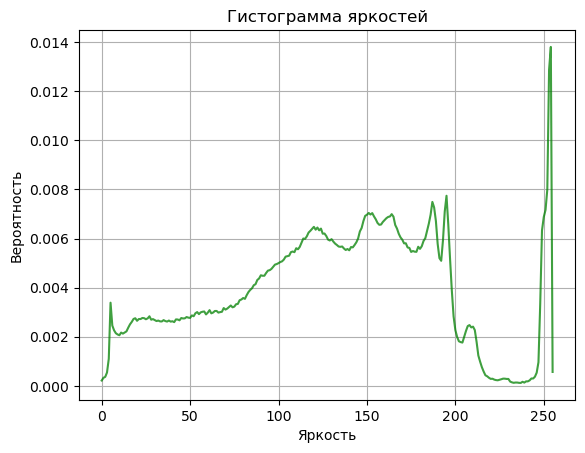

In [77]:
plt.plot(unique, norm_counts, color='g', alpha=0.75)

plt.xlabel('Яркость')
plt.ylabel('Вероятность')
plt.title('Гистограмма яркостей')
plt.grid(True)
plt.savefig("files/4/norm.jpg")
plt.show()

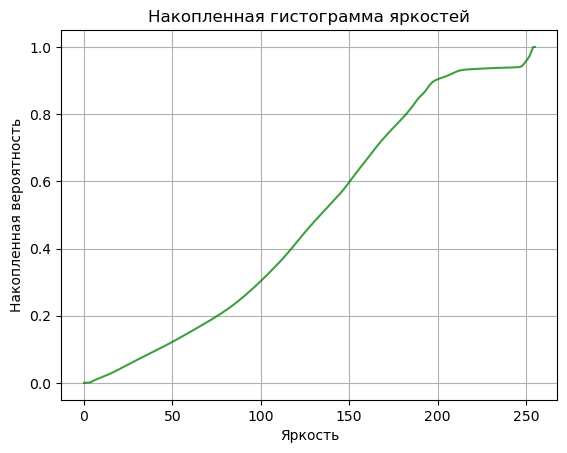

In [78]:
plt.plot(unique, stacked_counts, color='g', alpha=0.75)

plt.xlabel('Яркость')
plt.ylabel('Накопленная вероятность')
plt.title('Накопленная гистограмма яркостей')
plt.grid(True)
plt.savefig("files/4/stacked.jpg")
plt.show()

#### б) Провести выравнивание гистограмм по различным распределениям
Источник: https://en.wikipedia.org/wiki/Histogram_matching, https://stackoverflow.com/questions/32655686/histogram-matching-of-two-images-in-python-2-x

In [79]:
def histogram_matching(source: np.array, 
                       target_distribution: np.array) -> (np.array, np.array):
    source_unique, source_indexes, source_counts = np.unique(source, return_inverse=True, return_counts=True)
    source_norm_counts = source_counts / np.sum(source_counts)
    source_stacked_counts = np.cumsum(source_norm_counts)

    target_norm_counts = target_distribution / np.sum(target_distribution)
    target_stacked_counts = np.cumsum(target_norm_counts)

    interp_values = np.interp(source_stacked_counts, target_stacked_counts, source_unique)
    return (interp_values[source_indexes].reshape(source.shape).astype(np.uint8),
           target_stacked_counts)
    

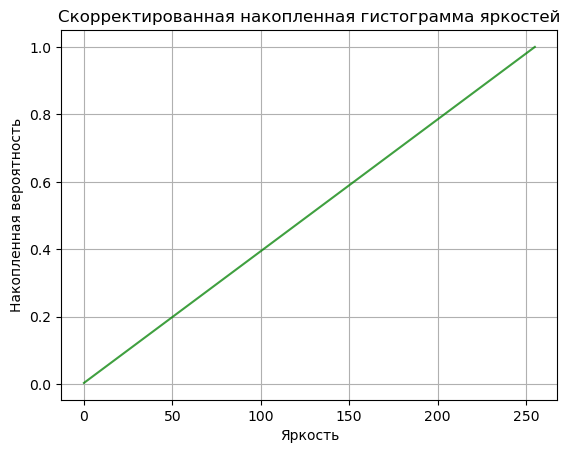

In [80]:
f_uniform = np.full((P,), K)

after_correct_image, after_correct_dist = histogram_matching(img_array, f_uniform)
Image.fromarray(after_correct_image).save('files/4/corrected_image_uniform.jpg')

plt.plot(range(len(after_correct_dist)), after_correct_dist, color='g', alpha=0.75)

plt.xlabel('Яркость')
plt.ylabel('Накопленная вероятность')
plt.title('Скорректированная накопленная гистограмма яркостей')
plt.grid(True)
plt.savefig("files/4/corrected_dist_uniform.jpg")
plt.show()

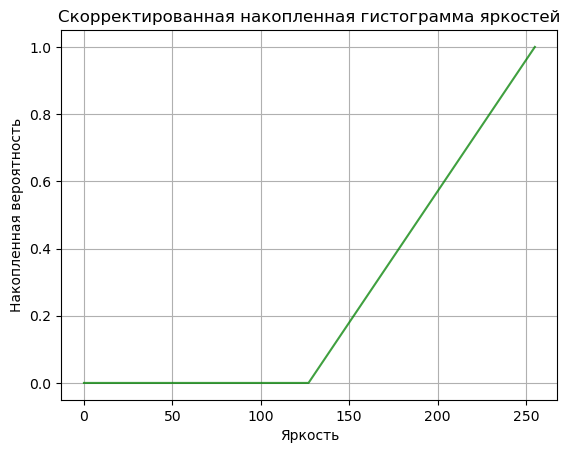

In [81]:
f_triangle = np.zeros((P,))
f_triangle[0: P//2] = K * f_triangle[0: P//2]
f_triangle[P//2: P] = K * (255 - f_triangle[P//2: P])

after_correct_image, after_correct_dist = histogram_matching(img_array, f_triangle)
Image.fromarray(after_correct_image).save('files/4/corrected_image_triangle.jpg')

plt.plot(range(len(after_correct_dist)), after_correct_dist, color='g', alpha=0.75)

plt.xlabel('Яркость')
plt.ylabel('Накопленная вероятность')
plt.title('Скорректированная накопленная гистограмма яркостей')
plt.grid(True)
plt.savefig("files/4/corrected_dist_triangle.jpg")
plt.show()

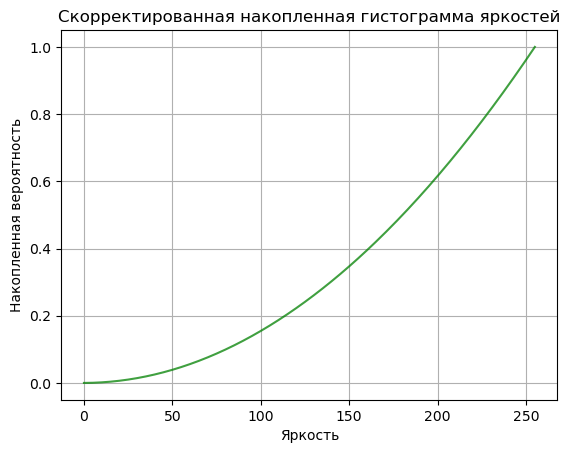

In [82]:
f_right_triangle = K * np.arange(P)

after_correct_image, after_correct_dist = histogram_matching(img_array, f_right_triangle)
Image.fromarray(after_correct_image).save('files/4/corrected_image_right_triangle.jpg')

plt.plot(range(len(after_correct_dist)), after_correct_dist, color='g', alpha=0.75)

plt.xlabel('Яркость')
plt.ylabel('Накопленная вероятность')
plt.title('Скорректированная накопленная гистограмма яркостей')
plt.grid(True)
plt.savefig("files/4/corrected_dist_right_triangle.jpg")
plt.show()

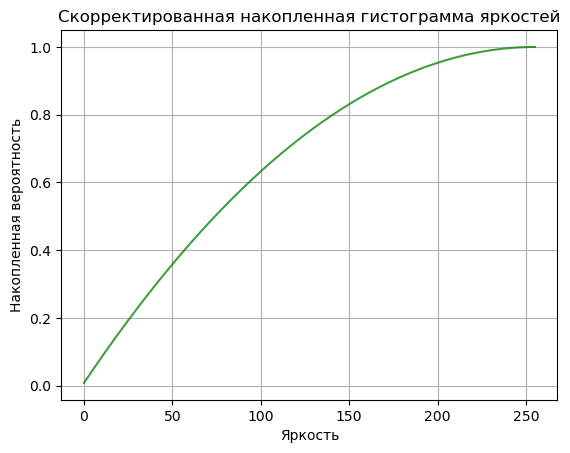

In [83]:
f_left_triangle = K * (P - np.arange(P))

after_correct_image, after_correct_dist = histogram_matching(img_array, f_left_triangle)
Image.fromarray(after_correct_image).save('files/4/corrected_image_left_triangle.jpg')

plt.plot(range(len(after_correct_dist)), after_correct_dist, color='g', alpha=0.75)

plt.xlabel('Яркость')
plt.ylabel('Накопленная вероятность')
plt.title('Скорректированная накопленная гистограмма яркостей')
plt.grid(True)
plt.savefig("files/4/corrected_dist_left_triangle.jpg")
plt.show()

#### в) Провести адаптивное выравнивание гистограммы (AHE) без отсечения контраста для различных размеров черепичного разбиения изображения
Источник: https://github.com/prat1kbhujbal/Histogram_Equalization/blob/main/code/histogram_eq.py

In [84]:
def hist_equalization(mini_img, clahe_param=None):
    
    bin_cont = np.bincount(mini_img.flatten(), minlength=256)
    pixels = np.sum(bin_cont)
    bin_cont = bin_cont / pixels
    if clahe_param:
        bin_cont = np.where(bin_cont > clahe_param, np.full(clahe_param, bin_cont.shape), bin_cont)
    bin_cont = bin_cont / np.sum(bin_cont)
    cumulative_sumhist = np.cumsum(bin_cont)
    map = np.floor(255 * cumulative_sumhist).astype(np.uint8)
    arr_list = list(mini_img.flatten())
    eq_arr = [map[p] for p in arr_list]
    arr_back = np.reshape(np.asarray(eq_arr), mini_img.shape)
    return arr_back

def AHE(img_array: np.array, sq_size:int, clahe_param=None):
    img_eq = np.empty((img_array.shape[0], img_array.shape[1]), dtype=np.uint8)
    for i in range(0, img_array.shape[1], sq_size):
        for j in range(0, img_array.shape[0], sq_size):
            t = img_array[j:j + sq_size, i:i + sq_size]
            c = hist_equalization(t)
            img_eq[j:j + sq_size, i:i + sq_size] = c

    new_img_array = bilinear_interpolation(img_eq, img_eq.shape).astype(np.uint8)
    return new_img_array

def bilinear_interpolation(image, dimension):

    height = image.shape[0]
    width = image.shape[1]

    scale_x = (width)/(dimension[1])
    scale_y = (height)/(dimension[0])

    new_image = np.zeros((dimension[0], dimension[1]))

    for i in range(dimension[0]):
        for j in range(dimension[1]):
            x = (j+0.5) * (scale_x) - 0.5
            y = (i+0.5) * (scale_y) - 0.5

            x_int = int(x)
            y_int = int(y)

            # Prevent crossing
            x_int = min(x_int, width-2)
            y_int = min(y_int, height-2)

            x_diff = x - x_int
            y_diff = y - y_int

            a = image[y_int, x_int]
            b = image[y_int, x_int+1]
            c = image[y_int+1, x_int]
            d = image[y_int+1, x_int+1]

            pixel = a*(1-x_diff)*(1-y_diff) + b*(x_diff) * \
                    (1-y_diff) + c*(1-x_diff) * (y_diff) + d*x_diff*y_diff

            new_image[i, j] = pixel.astype(np.uint8)

    return new_image

In [85]:
for sq_size in [4, 8, 16, 32]:
    Image.fromarray(AHE(img_array, sq_size=8, clahe_param=None)).save(f'files/4/AHE-{sq_size}.jpg')

#### г) Провести адаптивное выравнивание гистограммы (CLAHE) с различными уровнями отсечения контраста. Размер черепичного разбиения выбрать 8 на 8

In [86]:
for cl in [0.001, 0.01, 0.1, 1]:
    Image.fromarray(AHE(img_array, 8, cl)).save(f'files/4/CLAHE-{cl}.jpg')